<a href="https://colab.research.google.com/github/adityasaich/sasi_btp/blob/main/sasi_btp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np

In [17]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [18]:
id = '18xGNPuvbXGSN97g0CzI1tIBl81zJrToF'

In [25]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.csv')  
df_input = pd.read_csv('dataset.csv')
#df_input = df_input.sample(n=50000)

In [ ]:
#url = 'https://raw.githubusercontent.com/adityasaich/sasi_btp/main/dataworld_set.csv?token=ALPKPQCX3COGEIP65QDO2V3BR5QT6'
#df_input = pd.read_csv(url)

In [20]:
def deviationTransform(arr):
  m = np.mean(arr)
  d = np.std(arr)
  return [m,d]
def minMaxTransform(arr):
  min = np.min(arr)
  max = np.max(arr)
  return [min,max-min]

In [26]:
#pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
df_input = df_input[df_input['Area'] > 0 ]
df_input = df_input[df_input['Production'] > 0 ]
df_input["ProductionPerArea"] = ((df_input["Production"])/(df_input["Area"]))
#dropping columns which are not used
df_input = df_input.drop(columns=['District_Name','Crop_Year','Area','Production'])
#replace empty strings with nan
df_input = df_input.replace(r'^\s*$', np.NaN, regex=True)
#drop null values
df_input = df_input.dropna()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    238838.000000
mean         42.263407
std         823.564866
min           0.000003
25%           0.532242
50%           1.000000
75%           2.400000
max       88000.000000
Name: ProductionPerArea, dtype: float64


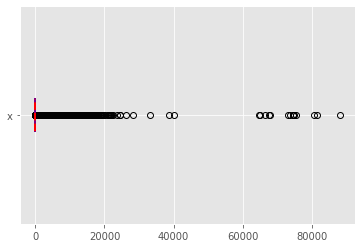

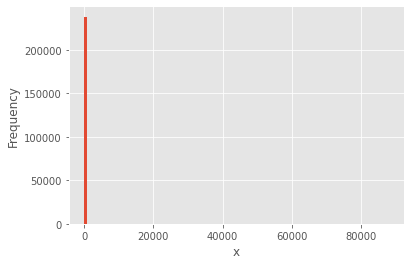

In [27]:
x = df_input['ProductionPerArea']
print(x.describe())

import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.boxplot((x), vert=False, showmeans=True, meanline=True,
           labels=('x'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()
hist, bin_edges = np.histogram(x, bins=100)
fig, ax = plt.subplots()
ax.hist(x, bin_edges, cumulative=False)
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
plt.show()

In [28]:
categorical_columns = ['State_Name', 'Crop' ,'Season']
#label encoder dict
labels_dict = {}
#scaling dict
scaling_dict = {}
for column in categorical_columns:
  le = LabelEncoder()
  le.fit(df_input[column])
  df_input[column] = le.transform(df_input[column])
  labels_dict[column] = le.classes_
  scaling_params = minMaxTransform(np.array(df_input[column]))
  df_input[column] = (df_input[column] - scaling_params[0])/scaling_params[1]
  scaling_dict[column] = scaling_params
scaling_params = deviationTransform(np.array(df_input['ProductionPerArea']))
df_input['ProductionPerArea'] = (df_input['ProductionPerArea'] - scaling_params[0])/scaling_params[1]
scaling_dict['ProductionPerArea'] = scaling_params

In [29]:
scaling_dict

{'Crop': [0, 104],
 'ProductionPerArea': [42.26340712371502, 823.5631416601492],
 'Season': [0, 5],
 'State_Name': [0, 32]}

In [30]:
from sklearn.model_selection import train_test_split
df_small = df_input
df_small.columns.name = None
df=df_small
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.33, random_state=42)
print(x_train,y_train)

        State_Name  Season      Crop
190852     0.84375     0.2  0.836538
16928      0.09375     0.4  0.519231
158821     0.68750     1.0  0.750000
15637      0.09375     0.6  0.769231
37586      0.12500     0.2  0.817308
...            ...     ...       ...
124415     0.50000     0.8  0.269231
107164     0.50000     0.2  0.769231
136701     0.53125     0.2  0.557692
151694     0.68750     0.6  0.836538
126573     0.53125     0.2  0.500000

[160021 rows x 3 columns] 190852   -0.050897
16928    -0.050778
158821   -0.051122
15637    -0.050392
37586    -0.046821
            ...   
124415   -0.050978
107164   -0.050662
136701   -0.050971
151694   -0.051104
126573   -0.048287
Name: ProductionPerArea, Length: 160021, dtype: float64


In [31]:
from sklearn.metrics import mean_squared_error
def classify(clf,x_train,x_test,y_train,y_test):
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_test)
  print(y_pred)
  y_train_pred = clf.predict(x_train)
  print(mean_squared_error(y_train, y_train_pred))
  print(mean_squared_error(y_test, y_pred))
  print(y_pred)
  print(y_test)

In [ ]:
#using kernel ridge crashing with ram limit excedded
from sklearn.kernel_ridge import KernelRidge
krr_clf = KernelRidge(alpha=1.0)
print("\t\t\t kernel-ridge classifier")
classify(krr_clf,x_train,x_test,y_train,y_test)

			 kernel-ridge classifier


In [32]:
from sklearn.ensemble import RandomForestRegressor
regresser = RandomForestRegressor(n_estimators = 10 ,random_state = 0)
print("\t\t\t random-forest classifier")
classify(regresser,x_train,x_test,y_train,y_test)

			 random-forest classifier
[ 0.00361644 -0.05050501 -0.04374779 ... -0.05067865 -0.02702237
 -0.04762243]
0.7278192223578155
0.41832777322236697
[ 0.00361644 -0.05050501 -0.04374779 ... -0.05067865 -0.02702237
 -0.04762243]
41416     0.000848
183710   -0.050528
71982    -0.050060
125632   -0.049879
180040   -0.044477
            ...   
12046    -0.050057
141176   -0.049323
192436   -0.050514
145546   -0.026729
58122    -0.047502
Name: ProductionPerArea, Length: 78817, dtype: float64


In [34]:
print(labels_dict)
print(scaling_dict)

{'State_Name': array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra and Nagar Haveli', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir ', 'Jharkhand',
       'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana ',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype=object), 'Crop': array(['Arcanut (Processed)', 'Arecanut', 'Arhar/Tur', 'Atcanut (Raw)',
       'Bajra', 'Banana', 'Barley', 'Bean', 'Beans & Mutter(Vegetable)',
       'Bhindi', 'Bitter Gourd', 'Black pepper', 'Blackgram',
       'Bottle Gourd', 'Brinjal', 'Cabbage', 'Cardamom', 'Carrot',
       'Cashewnut', 'Cashewnut Processed', 'Cashewnut Raw', 'Castor seed',
       'Cauliflower', 'Citrus Fruit', 'Coconut ', 'Coffee', 'Colocosia',
   